In [2]:
import pandas as pd
import numpy as np

In [3]:
appid_info = pd.read_csv('../cleaned_data/appid_info_clean.csv')
transaction = pd.read_csv('../cleaned_data/transaction_clean.csv')
campaign_info = pd.read_csv('../cleaned_data/campaign_info_clean.csv')
map_card = pd.read_csv('../cleaned_data/map_card_clean.csv')
referral_history = pd.read_csv('../cleaned_data/referral_history_clean.csv')
transfer = pd.read_csv('../cleaned_data/transfer_clean.csv')
user_profile = pd.read_csv('../cleaned_data/user_profile_clean.csv')

In [ ]:
import pandas as pd
import numpy as np


df_user = user_profile.copy()

# === Chuẩn hóa dữ liệu thời gian ===
df_user['created_date'] = pd.to_datetime(df_user['created_date'], errors='coerce')

# Mốc tham chiếu (kết thúc chiến dịch)
ref_date = pd.Timestamp("2022-06-01 23:59:59")
# Thời điểm bắt đầu chiến dịch
campaign_start = pd.Timestamp("2021-09-01 10:00:00")

# === Xây dựng các metrics cơ bản ===

# Tuổi tài khoản (tính đến cuối chiến dịch)
df_user['account_age_days'] = (ref_date - df_user['created_date']).dt.days.clip(lower=0)

# Cờ: tài khoản tạo trong thời gian chiến dịch
df_user['created_during_campaign'] = (
    (df_user['created_date'] >= campaign_start) &
    (df_user['created_date'] <= ref_date)
).astype(int)

# Cờ: tài khoản mới (<7 ngày tuổi)
df_user['is_new_user'] = (df_user['account_age_days'] < 7).astype(int)

# === Chuẩn hóa dữ liệu danh mục ===
df_user['phone_provider'] = df_user['phone_provider'].fillna('unknown')
df_user['usergender'] = df_user['usergender'].fillna(0)

# === Tạo DataFrame kết quả lớp User Profile ===
user_metrics_base = df_user[[
    'userID',
    'account_age_days',
    'is_new_user',
    'created_during_campaign',
    'phone_provider',
    'usergender',
]].copy()



print("✅ Giai đoạn 1 (User Profile Metrics) hoàn tất.")
print(f"Số dòng: {user_metrics_base.shape[0]}, Số cột: {user_metrics_base.shape[1]}")
print(user_metrics_base.head())


✅ Giai đoạn 1 (User Profile Metrics) hoàn tất.
📏 Số dòng: 403465, Số cột: 7
                             userID  account_age_days  is_new_user  \
0  c0f75446daa8140e9ef90fb6c73e3a03              2365            0   
1  bfd4558e9fba3d36c1c0fdefc6ac2221              2293            0   
2  8d53ea3f700ecc6bea5811c987470ed6              2288            0   
3  48b1f4c7b01b16a1fb0b1c23ab29d702              2250            0   
4  3c73d35390202fb29d855d5a7a806363              2245            0   

   created_during_campaign  phone_provider  usergender  weekday_created  
0                        0            7653           1                3  
1                        0            7630           1                5  
2                        0            7050           1                3  
3                        0            7589           1                6  
4                        0            7052           1                4  


In [ ]:
import pandas as pd
import numpy as np

df_txn = transaction.copy()

# === Chuẩn hóa dữ liệu ===
df_txn['reqDate'] = pd.to_datetime(df_txn['reqDate'], errors='coerce')
df_txn['cashbackTime'] = pd.to_datetime(df_txn['cashbackTime'], errors='coerce')

# Chuyển các cột số sang numeric
numeric_cols = ['userChargeAmount', 'amount', 'discountAmount', 'transStatus']
for col in numeric_cols:
    df_txn[col] = pd.to_numeric(df_txn[col], errors='coerce').fillna(0)

# Giữ lại giao dịch thành công
df_txn = df_txn[df_txn['transStatus'] == 1].copy()

# === Tổng hợp theo user ===
txn_metrics = df_txn.groupby('userID').agg(
    txn_count=('transID', 'count'),
    txn_days_active=('reqDate', lambda x: x.dt.date.nunique()),
    avg_txn_amount=('amount', 'mean'),
    zero_charge_ratio=('userChargeAmount', lambda x: (x == 0).mean()),
    discount_ratio=('discountAmount', lambda x: (x > 0).mean()),
    cashback_ratio=('cashbackTime', lambda x: x.notna().mean()),
    unique_apps=('appID', pd.Series.nunique)
).reset_index()

# === Bổ sung metrics ===

# Giao dịch trung bình/ngày
txn_metrics['txn_per_day'] = (
    txn_metrics['txn_count'] / txn_metrics['txn_days_active'].replace(0, np.nan)
).fillna(0)

# Chỉ số đa dạng app (0–1)
txn_metrics['app_diversity_index'] = (
    txn_metrics['unique_apps'] / txn_metrics['unique_apps'].max()
).fillna(0)

# Mật độ giao dịch (txn_density)
txn_metrics['txn_density'] = txn_metrics['txn_per_day']

# Cờ "burst" – ít ngày nhưng nhiều giao dịch
q_days_low = txn_metrics['txn_days_active'].quantile(0.1)
q_count_high = txn_metrics['txn_count'].quantile(0.9)
txn_metrics['txn_burst_flag'] = (
    (txn_metrics['txn_days_active'] <= q_days_low) &
    (txn_metrics['txn_count'] >= q_count_high)
).astype(int)

# Cờ "low-value" – giao dịch nhỏ hơn 50% median
median_amt = txn_metrics['avg_txn_amount'].median()
txn_metrics['low_value_txn_flag'] = (txn_metrics['avg_txn_amount'] < 0.5 * median_amt).astype(int)

# Điểm spam tổng hợp (0–1)
txn_metrics['txn_spam_index'] = (
    0.4 * txn_metrics['zero_charge_ratio'] +
    0.3 * txn_metrics['cashback_ratio'] +
    0.2 * txn_metrics['discount_ratio'] +
    0.1 * (1 - txn_metrics['app_diversity_index'])
)

# Cờ "nghi ngờ" – mật độ cao và giá trị thấp
q_density_high = txn_metrics['txn_density'].quantile(0.9)
q_amt_low = txn_metrics['avg_txn_amount'].quantile(0.25)
txn_metrics['txn_suspicious_flag'] = (
    (txn_metrics['txn_density'] >= q_density_high) &
    (txn_metrics['avg_txn_amount'] <= q_amt_low)
).astype(int)

# === Làm sạch ===
txn_metrics = txn_metrics.fillna(0)

# === Kiểm tra kết quả ===
print("✅ Transaction Metrics Layer hoàn tất (v2).")
print(f"Số dòng: {txn_metrics.shape[0]}, Số cột: {txn_metrics.shape[1]}")
print(txn_metrics.head())


✅ Transaction Metrics Layer hoàn tất (v2).
📏 Số dòng: 112406, Số cột: 15
                             userID  txn_count  txn_days_active  \
0  000003568a60cf019c30f1d2a84f6270         12                1   
1  000031baacd8171bcf0eff095481643e          2                1   
2  000031fd0fbb6dba745b48ae7e204be4          6                4   
3  0000d231b1beab1ff24622c48904a06a         21                7   
4  0000f2b07b93758d0649e5995c2f6620         13                2   

   avg_txn_amount  zero_charge_ratio  discount_ratio  cashback_ratio  \
0    88295.333333           0.416667        1.000000             1.0   
1    20000.000000           0.000000        0.500000             1.0   
2    82228.000000           0.333333        0.333333             1.0   
3     3333.333333           0.904762        0.952381             1.0   
4    71445.384615           0.615385        0.923077             1.0   

   unique_apps  txn_per_day  app_diversity_index  txn_density  txn_burst_flag  \
0         

In [ ]:
import pandas as pd
import numpy as np

df_transfer = transfer.copy()

# === Chuẩn hóa dữ liệu ===
df_transfer['reqDate'] = pd.to_datetime(df_transfer['reqDate'], errors='coerce')
df_transfer['amount'] = pd.to_numeric(df_transfer['amount'], errors='coerce').fillna(0)
df_transfer['transStatus'] = pd.to_numeric(df_transfer['transStatus'], errors='coerce').fillna(0)

# Lọc giao dịch thành công
df_transfer = df_transfer[df_transfer['transStatus'] == 1].copy()

# === Chuẩn hóa khóa: sender → userID ===
df_transfer = df_transfer.rename(columns={'sender': 'userID'})

# === Tổng hợp metrics theo userID (người gửi) ===
transfer_metrics = df_transfer.groupby('userID').agg(
    transfer_count=('transID', 'count'),
    transfer_days_active=('reqDate', lambda x: x.dt.date.nunique()),
    avg_transfer_amount=('amount', 'mean'),
    unique_receivers=('receiver', pd.Series.nunique),
    unique_devices=('deviceID', pd.Series.nunique),
    unique_platforms=('platform', pd.Series.nunique)
).reset_index()

# === Bổ sung metrics mở rộng ===

# Tần suất chuyển/ngày
transfer_metrics['transfer_per_day'] = (
    transfer_metrics['transfer_count'] /
    transfer_metrics['transfer_days_active'].replace(0, np.nan)
).fillna(0)

# Người nhận/ngày
transfer_metrics['receivers_per_day'] = (
    transfer_metrics['unique_receivers'] /
    transfer_metrics['transfer_days_active'].replace(0, np.nan)
).fillna(0)

# Tỷ lệ người nhận trùng lặp
transfer_metrics['receiver_repeat_ratio'] = (
    1 - (transfer_metrics['unique_receivers'] / transfer_metrics['transfer_count'].replace(0, np.nan))
).fillna(0)

# Cờ giao dịch giá trị thấp
median_amt = transfer_metrics['avg_transfer_amount'].median()
transfer_metrics['low_value_transfer_flag'] = (transfer_metrics['avg_transfer_amount'] < 0.5 * median_amt).astype(int)

# Cờ burst (bùng nổ): ít ngày nhưng nhiều giao dịch
q_days_low = transfer_metrics['transfer_days_active'].quantile(0.1)
q_count_high = transfer_metrics['transfer_count'].quantile(0.9)
transfer_metrics['transfer_burst_flag'] = (
    (transfer_metrics['transfer_days_active'] <= q_days_low) &
    (transfer_metrics['transfer_count'] >= q_count_high)
).astype(int)

# Điểm spam tổng hợp
transfer_metrics['transfer_spam_index'] = (
    0.4 * (transfer_metrics['transfer_per_day'] / transfer_metrics['transfer_per_day'].max()) +
    0.3 * (transfer_metrics['receivers_per_day'] / transfer_metrics['receivers_per_day'].max()) +
    0.2 * transfer_metrics['receiver_repeat_ratio'] +
    0.1 * (1 - transfer_metrics['unique_platforms'] / transfer_metrics['unique_platforms'].max())
).fillna(0)

# Cờ nghi ngờ: nhiều giao dịch, giá trị nhỏ
q_freq_high = transfer_metrics['transfer_per_day'].quantile(0.9)
q_amt_low = transfer_metrics['avg_transfer_amount'].quantile(0.25)
transfer_metrics['transfer_suspicious_flag'] = (
    (transfer_metrics['transfer_per_day'] >= q_freq_high) &
    (transfer_metrics['avg_transfer_amount'] <= q_amt_low)
).astype(int)

# === Làm sạch ===
transfer_metrics = transfer_metrics.fillna(0)

# === Xem kết quả ===
print("✅ Transfer Metrics Layer hoàn tất (sender → userID).")
print(f"Số dòng: {transfer_metrics.shape[0]}, Số cột: {transfer_metrics.shape[1]}")
print(transfer_metrics.head())


✅ Transfer Metrics Layer hoàn tất (sender → userID).
📏 Số dòng: 119357, Số cột: 14
                             userID  transfer_count  transfer_days_active  \
0  000003568a60cf019c30f1d2a84f6270               3                     1   
1  000031baacd8171bcf0eff095481643e               1                     1   
2  000031fd0fbb6dba745b48ae7e204be4               3                     1   
3  00003f9ea3a285ff3ffc8c9f97df9125               3                     2   
4  0000d231b1beab1ff24622c48904a06a               3                     1   

   avg_transfer_amount  unique_receivers  unique_devices  unique_platforms  \
0         97814.666667                 1               1                 1   
1         10000.000000                 1               1                 1   
2         34078.000000                 1               1                 1   
3         17400.000000                 1               1                 1   
4         23666.666667                 1               1        

In [ ]:
import pandas as pd
import numpy as np

df_ref = referral_history.copy()

# === Chuẩn hóa dữ liệu ===
df_ref['reqDate'] = pd.to_datetime(df_ref['reqDate'], errors='coerce')

# === Tổng hợp metrics theo người gửi (userID) ===
ref_metrics = df_ref.groupby('userID').agg(
    referrals_sent=('refereeId', 'count'),
    unique_referees=('refereeId', pd.Series.nunique),
    referral_days_active=('reqDate', lambda x: x.dt.date.nunique())
).reset_index()

# === Bổ sung metrics nâng cao ===

# Số lời mời/ngày
ref_metrics['referrals_per_day'] = (
    ref_metrics['referrals_sent'] /
    ref_metrics['referral_days_active'].replace(0, np.nan)
).fillna(0)

# Người được mời/ngày
ref_metrics['unique_referees_per_day'] = (
    ref_metrics['unique_referees'] /
    ref_metrics['referral_days_active'].replace(0, np.nan)
).fillna(0)

# Khoảng cách trung bình giữa các lời mời (giờ)
def avg_ref_interval(x):
    if len(x) < 2:
        return np.nan
    diffs = x.sort_values().diff().dropna()
    return diffs.mean().total_seconds() / 3600  # giờ

ref_interval = df_ref.groupby('userID')['reqDate'].apply(avg_ref_interval).reset_index(name='avg_referral_interval_hours')
ref_metrics = ref_metrics.merge(ref_interval, on='userID', how='left')

# Cờ burst – ít ngày, nhiều lời mời
q_days_low = ref_metrics['referral_days_active'].quantile(0.1)
q_ref_high = ref_metrics['referrals_sent'].quantile(0.9)
ref_metrics['referral_burst_flag'] = (
    (ref_metrics['referral_days_active'] <= q_days_low) &
    (ref_metrics['referrals_sent'] >= q_ref_high)
).astype(int)

# Cờ “nhiều người mời bất thường”
q_referees_high = ref_metrics['unique_referees'].quantile(0.95)
ref_metrics['many_referees_flag'] = (ref_metrics['unique_referees'] >= q_referees_high).astype(int)

# Điểm spam tổng hợp
ref_metrics['referral_spam_index'] = (
    0.5 * (ref_metrics['referrals_per_day'] / ref_metrics['referrals_per_day'].max()) +
    0.3 * (1 / (ref_metrics['avg_referral_interval_hours'].replace(0, np.nan))) +
    0.2 * (ref_metrics['unique_referees_per_day'] / ref_metrics['unique_referees_per_day'].max())
).fillna(0)

# Cờ nghi ngờ (spam nhanh và nhiều người)
q_speed_high = ref_metrics['referrals_per_day'].quantile(0.9)
q_interval_low = ref_metrics['avg_referral_interval_hours'].quantile(0.1)
ref_metrics['referral_suspicious_flag'] = (
    (ref_metrics['referrals_per_day'] >= q_speed_high) &
    (ref_metrics['avg_referral_interval_hours'] <= q_interval_low)
).astype(int)

# === Làm sạch ===
ref_metrics = ref_metrics.fillna(0)

# === Kết quả ===
print("✅ Referral Metrics Layer hoàn tất.")
print(f"Số dòng: {ref_metrics.shape[0]}, Số cột: {ref_metrics.shape[1]}")
print(ref_metrics.head())


✅ Referral Metrics Layer hoàn tất.
📏 Số dòng: 309024, Số cột: 11
                             userID  referrals_sent  unique_referees  \
0  000003568a60cf019c30f1d2a84f6270               8                4   
1  000031fd0fbb6dba745b48ae7e204be4               2                1   
2  0000719865f3126396389054b1146d15               1                1   
3  000083d0c5d50dd244c8d01f479a8d99               1                1   
4  0000d231b1beab1ff24622c48904a06a               4                3   

   referral_days_active  referrals_per_day  unique_referees_per_day  \
0                     1           8.000000                      4.0   
1                     1           2.000000                      1.0   
2                     1           1.000000                      1.0   
3                     1           1.000000                      1.0   
4                     3           1.333333                      1.0   

   avg_referral_interval_hours  referral_burst_flag  many_referees_flag  \


In [ ]:
import pandas as pd
import numpy as np

# === Đọc dữ liệu ===
# map_card = pd.read_csv("../feature_set/map_card.csv")
df_card = map_card.copy()

# === Chuẩn hóa dữ liệu ===
df_card['reqDate'] = pd.to_datetime(df_card['reqDate'], errors='coerce')
df_card['requestStatus'] = pd.to_numeric(df_card['requestStatus'], errors='coerce').fillna(0)

# Lọc liên kết thành công
df_card = df_card[df_card['requestStatus'] == 1].copy()

# === Tổng hợp metrics theo userID ===
card_metrics = df_card.groupby('userID').agg(
    cards_linked=('bimID', pd.Series.nunique),
    linked_days_active=('reqDate', lambda x: x.dt.date.nunique()),
    banks_diversity=('bankname', pd.Series.nunique)
).reset_index()

# === Tính tần suất liên kết/ngày ===
card_metrics['cards_per_day'] = (
    card_metrics['cards_linked'] /
    card_metrics['linked_days_active'].replace(0, np.nan)
).fillna(0)

# === Tính người dùng chia sẻ thẻ (users_per_card) ===
users_per_card = df_card.groupby('bimID')['userID'].nunique().reset_index(name='users_per_card')
df_card = df_card.merge(users_per_card, on='bimID', how='left')

# Trung bình số người/thẻ cho mỗi user
avg_users = df_card.groupby('userID')['users_per_card'].mean().reset_index(name='avg_users_per_card')
card_metrics = card_metrics.merge(avg_users, on='userID', how='left')

# === Sinh các cờ bất thường ===

# Cờ nhiều thẻ liên kết
q_card_high = card_metrics['cards_linked'].quantile(0.95)
card_metrics['multi_card_flag'] = (card_metrics['cards_linked'] >= q_card_high).astype(int)

# Cờ chia sẻ thẻ
q_shared_high = card_metrics['avg_users_per_card'].quantile(0.95)
card_metrics['shared_card_flag'] = (card_metrics['avg_users_per_card'] >= q_shared_high).astype(int)

# Cờ nghi ngờ tổng hợp
card_metrics['mapcard_suspicious_flag'] = (
    (card_metrics['multi_card_flag'] == 1) |
    (card_metrics['shared_card_flag'] == 1)
).astype(int)

# === Làm sạch ===
card_metrics = card_metrics.fillna(0)

# === Kết quả ===
print("✅ Map Card Metrics Layer hoàn tất.")
print(f"Số dòng: {card_metrics.shape[0]}, Số cột: {card_metrics.shape[1]}")
print(card_metrics.head())


✅ Map Card Metrics Layer hoàn tất.
📏 Số dòng: 84282, Số cột: 9
                             userID  cards_linked  linked_days_active  \
0  000003568a60cf019c30f1d2a84f6270             2                   2   
1  000031baacd8171bcf0eff095481643e             1                   1   
2  000031fd0fbb6dba745b48ae7e204be4             1                   1   
3  0000f2b07b93758d0649e5995c2f6620             1                   1   
4  000114e98e3e3b6dd3c9934a764e6d39             1                   1   

   banks_diversity  cards_per_day  avg_users_per_card  multi_card_flag  \
0                2            1.0                 1.0                1   
1                1            1.0                 1.0                0   
2                1            1.0                 1.0                0   
3                1            1.0                 1.0                0   
4                1            1.0                 1.0                0   

   shared_card_flag  mapcard_suspicious_flag  
0     

In [ ]:
# --- Merge tất cả các metrics layer lại ---
feature_set = (
    user_metrics_base
    .merge(txn_metrics, on='userID', how='left')
    .merge(transfer_metrics, on='userID', how='left')
    .merge(ref_metrics, on='userID', how='left')
    .merge(card_metrics, on='userID', how='left')
)

# --- Điền giá trị thiếu ---
feature_set = feature_set.fillna(0)

# --- Kiểm tra kích thước ---
print("✅ Tổng hợp user feature set hoàn tất.")
print(f"Số dòng: {feature_set.shape[0]}, Số cột: {feature_set.shape[1]}")
print(feature_set.head())

# --- (Tùy chọn) Xuất ra file ---
feature_set.to_csv("../feature_set/user_feature_set.csv", index=False, encoding="utf-8-sig")


✅ Tổng hợp user feature set hoàn tất.
📏 Số dòng: 403465, Số cột: 52
                             userID  account_age_days  is_new_user  \
0  c0f75446daa8140e9ef90fb6c73e3a03              2365            0   
1  bfd4558e9fba3d36c1c0fdefc6ac2221              2293            0   
2  8d53ea3f700ecc6bea5811c987470ed6              2288            0   
3  48b1f4c7b01b16a1fb0b1c23ab29d702              2250            0   
4  3c73d35390202fb29d855d5a7a806363              2245            0   

   created_during_campaign  phone_provider  usergender  weekday_created  \
0                        0            7653           1                3   
1                        0            7630           1                5   
2                        0            7050           1                3   
3                        0            7589           1                6   
4                        0            7052           1                4   

   txn_count  txn_days_active  avg_txn_amount  ...  referral

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("../feature_set/user_feature_set.csv")

# --- Bảo đảm các cột flag tồn tại (nếu thiếu thì thêm giá trị 0) ---
flag_cols = [
    'txn_suspicious_flag', 'transfer_suspicious_flag', 'referral_suspicious_flag', 'mapcard_suspicious_flag',
    'shared_card_flag', 'multi_card_flag', 'transfer_burst_flag', 'referral_burst_flag'
]
for col in flag_cols:
    if col not in df.columns:
        df[col] = 0

# --- Thêm nhóm soft risk (nếu có các chỉ số spam) ---
spam_cols = ['txn_spam_index', 'transfer_spam_index', 'referral_spam_index']
for col in spam_cols:
    if col in df.columns:
        threshold = df[col].quantile(0.9)
        df[f"{col}_flag"] = (df[col] >= threshold).astype(int)
    else:
        df[f"{col}_flag"] = 0

# --- Tính tổng điểm risk ---
df['risk_score'] = (
    2 * (df['txn_suspicious_flag'] + df['transfer_suspicious_flag'] + 
         df['referral_suspicious_flag'] + df['mapcard_suspicious_flag'])
    + 3 * (df['shared_card_flag'] + df['multi_card_flag'] +
           df['transfer_burst_flag'] + df['referral_burst_flag'])
    + 1 * (df['txn_spam_index_flag'] + df['transfer_spam_index_flag'] + df['referral_spam_index_flag'])
)

# --- Gán nhãn isBot ---
df['isBot'] = (df['risk_score'] >= 7).astype(int)

# --- Thống kê nhanh ---
print("✅ Rule-based labeling hoàn tất.")
print(f"Tổng số dòng: {df.shape[0]}")
print("📊 Phân bố nhãn:")
print(df['isBot'].value_counts())
print("📈 Tỷ lệ bot:", round(df['isBot'].mean()*100, 2), "%")




✅ Rule-based labeling hoàn tất.
Tổng số dòng: 403465
📊 Phân bố nhãn:
isBot
0    383768
1     19697
Name: count, dtype: int64
📈 Tỷ lệ bot: 4.88 %


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10756\2475395192.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels, y=counts.values, palette=colors, edgecolor='black')


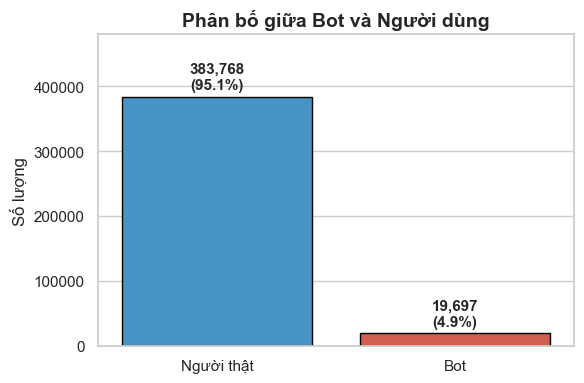

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("../feature_set/user_feature_set_label.csv")
counts = df['isBot'].value_counts().sort_index()
labels = ['Người thật', 'Bot']
colors = ['#3498db', '#e74c3c']

plt.figure(figsize=(6,4))
ax = sns.barplot(x=labels, y=counts.values, palette=colors, edgecolor='black')
plt.ylim(0, counts.max()*1.25)  

for i, v in enumerate(counts.values):
    pct = v / counts.sum() * 100
    ax.text(i, v + counts.max()*0.03, f"{v:,}\n({pct:.1f}%)", ha='center',
            fontsize=11, fontweight='bold')

plt.title("Phân bố giữa Bot và Người dùng", fontsize=14, fontweight='bold')
plt.ylabel("Số lượng", fontsize=12)
plt.tight_layout()
plt.show()


In [18]:
output_path = "../feature_set/user_feature_set_label.csv"
df.to_csv(output_path, index=False, encoding="utf-8-sig")
print(f"💾 File đã lưu tại: {output_path}")

💾 File đã lưu tại: ../feature_set/user_feature_set_label.csv
